In [79]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from fwi_predict.wq import get_in_required_range

In [80]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/jun_21_dec_24_w_metadata_predict_df.csv",
                         parse_dates=['sample_dt'],
                         index_col=0)

# Load sentinel features
sentinel_features = pd.read_csv("../data/gcs/train/sentinel2/jun_21_dec_24_w_metadata.csv").drop(columns=['system:index', '.geo'])
predict_df = predict_df.merge(sentinel_features, on='sample_idx')

num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'geometry'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
predict_df['morning'] = predict_df['hour'] < 12
predict_df['month'] = predict_df['sample_dt'].dt.month

predict_df = predict_df.drop(columns=['ammonia_mg_per_L', 'ph', 'turbidity_cm'])
predict_df['do_in_range'] = get_in_required_range('do_mg_per_L',
                                                  predict_df['do_mg_per_L'], 
                                                  predict_df['morning'].apply(lambda x: 'morning' if x else 'evening'))              

In [81]:
# Format for sktime
predict_df = predict_df.set_index(['pond_id', 'sample_dt'])

In [82]:
winkler_df = predict_df[predict_df['do_winkler']].copy()

In [83]:
y = winkler_df['do_mg_per_L']
X = winkler_df[winkler_df.columns[winkler_df.columns != 'do_mg_per_L'].tolist()]

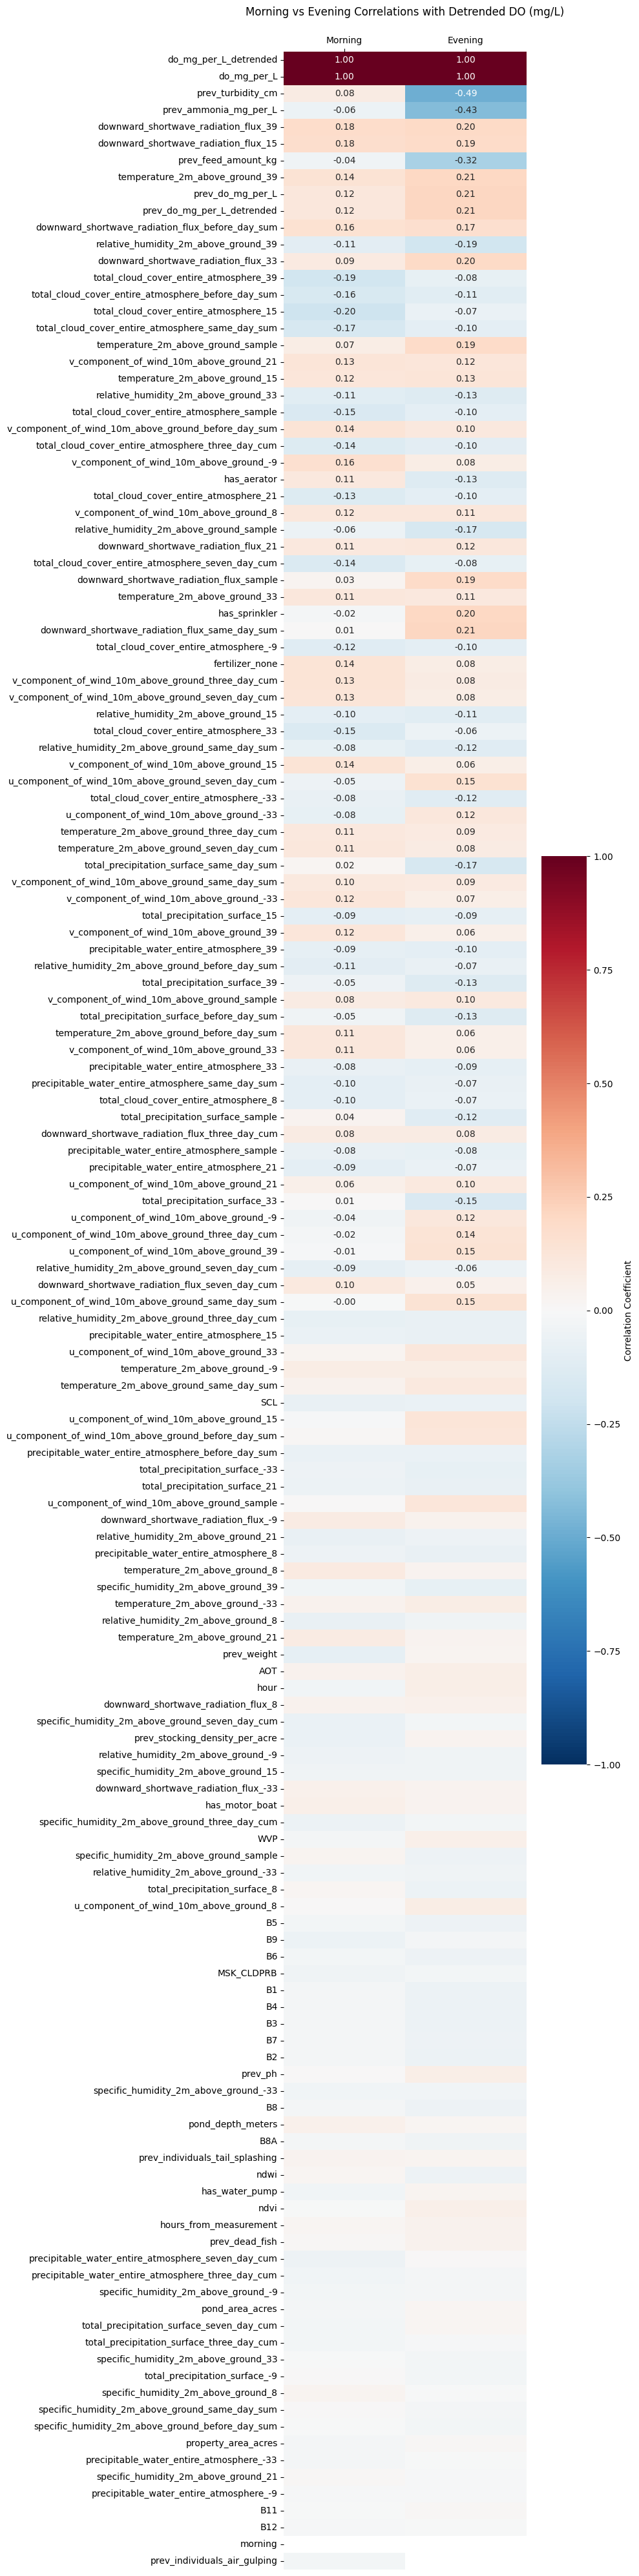

In [85]:
# Create copy of winkler_df and group by morning to detrend DO values
winkler_df = winkler_df.copy()
diurnal_means = winkler_df.groupby(['morning'])['do_mg_per_L'].transform('mean')
winkler_df['do_mg_per_L_detrended'] = winkler_df['do_mg_per_L'] - diurnal_means
winkler_df['prev_do_mg_per_L_detrended'] = winkler_df['prev_do_mg_per_L'] - diurnal_means

# Calculate correlations separately for morning and evening
numeric_cols = winkler_df.select_dtypes(include=['float64', 'int64', 'bool']).columns.drop(['do_winkler'])

morning_corr = winkler_df[winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']
evening_corr = winkler_df[~winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']

# Combine correlations into a DataFrame
corr_comparison = pd.DataFrame({
    'Morning': morning_corr,
    'Evening': evening_corr
})
corr_comparison['Total'] = corr_comparison['Morning'].abs() + corr_comparison['Evening'].abs()
corr_comparison = corr_comparison.sort_values('Total', ascending=False).drop('Total', axis=1)

# Create heatmap
plt.figure(figsize=(10, 40))
sns.heatmap(corr_comparison,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Morning vs Evening Correlations with Detrended DO (mg/L)', pad=40)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.tight_layout()
plt.show()


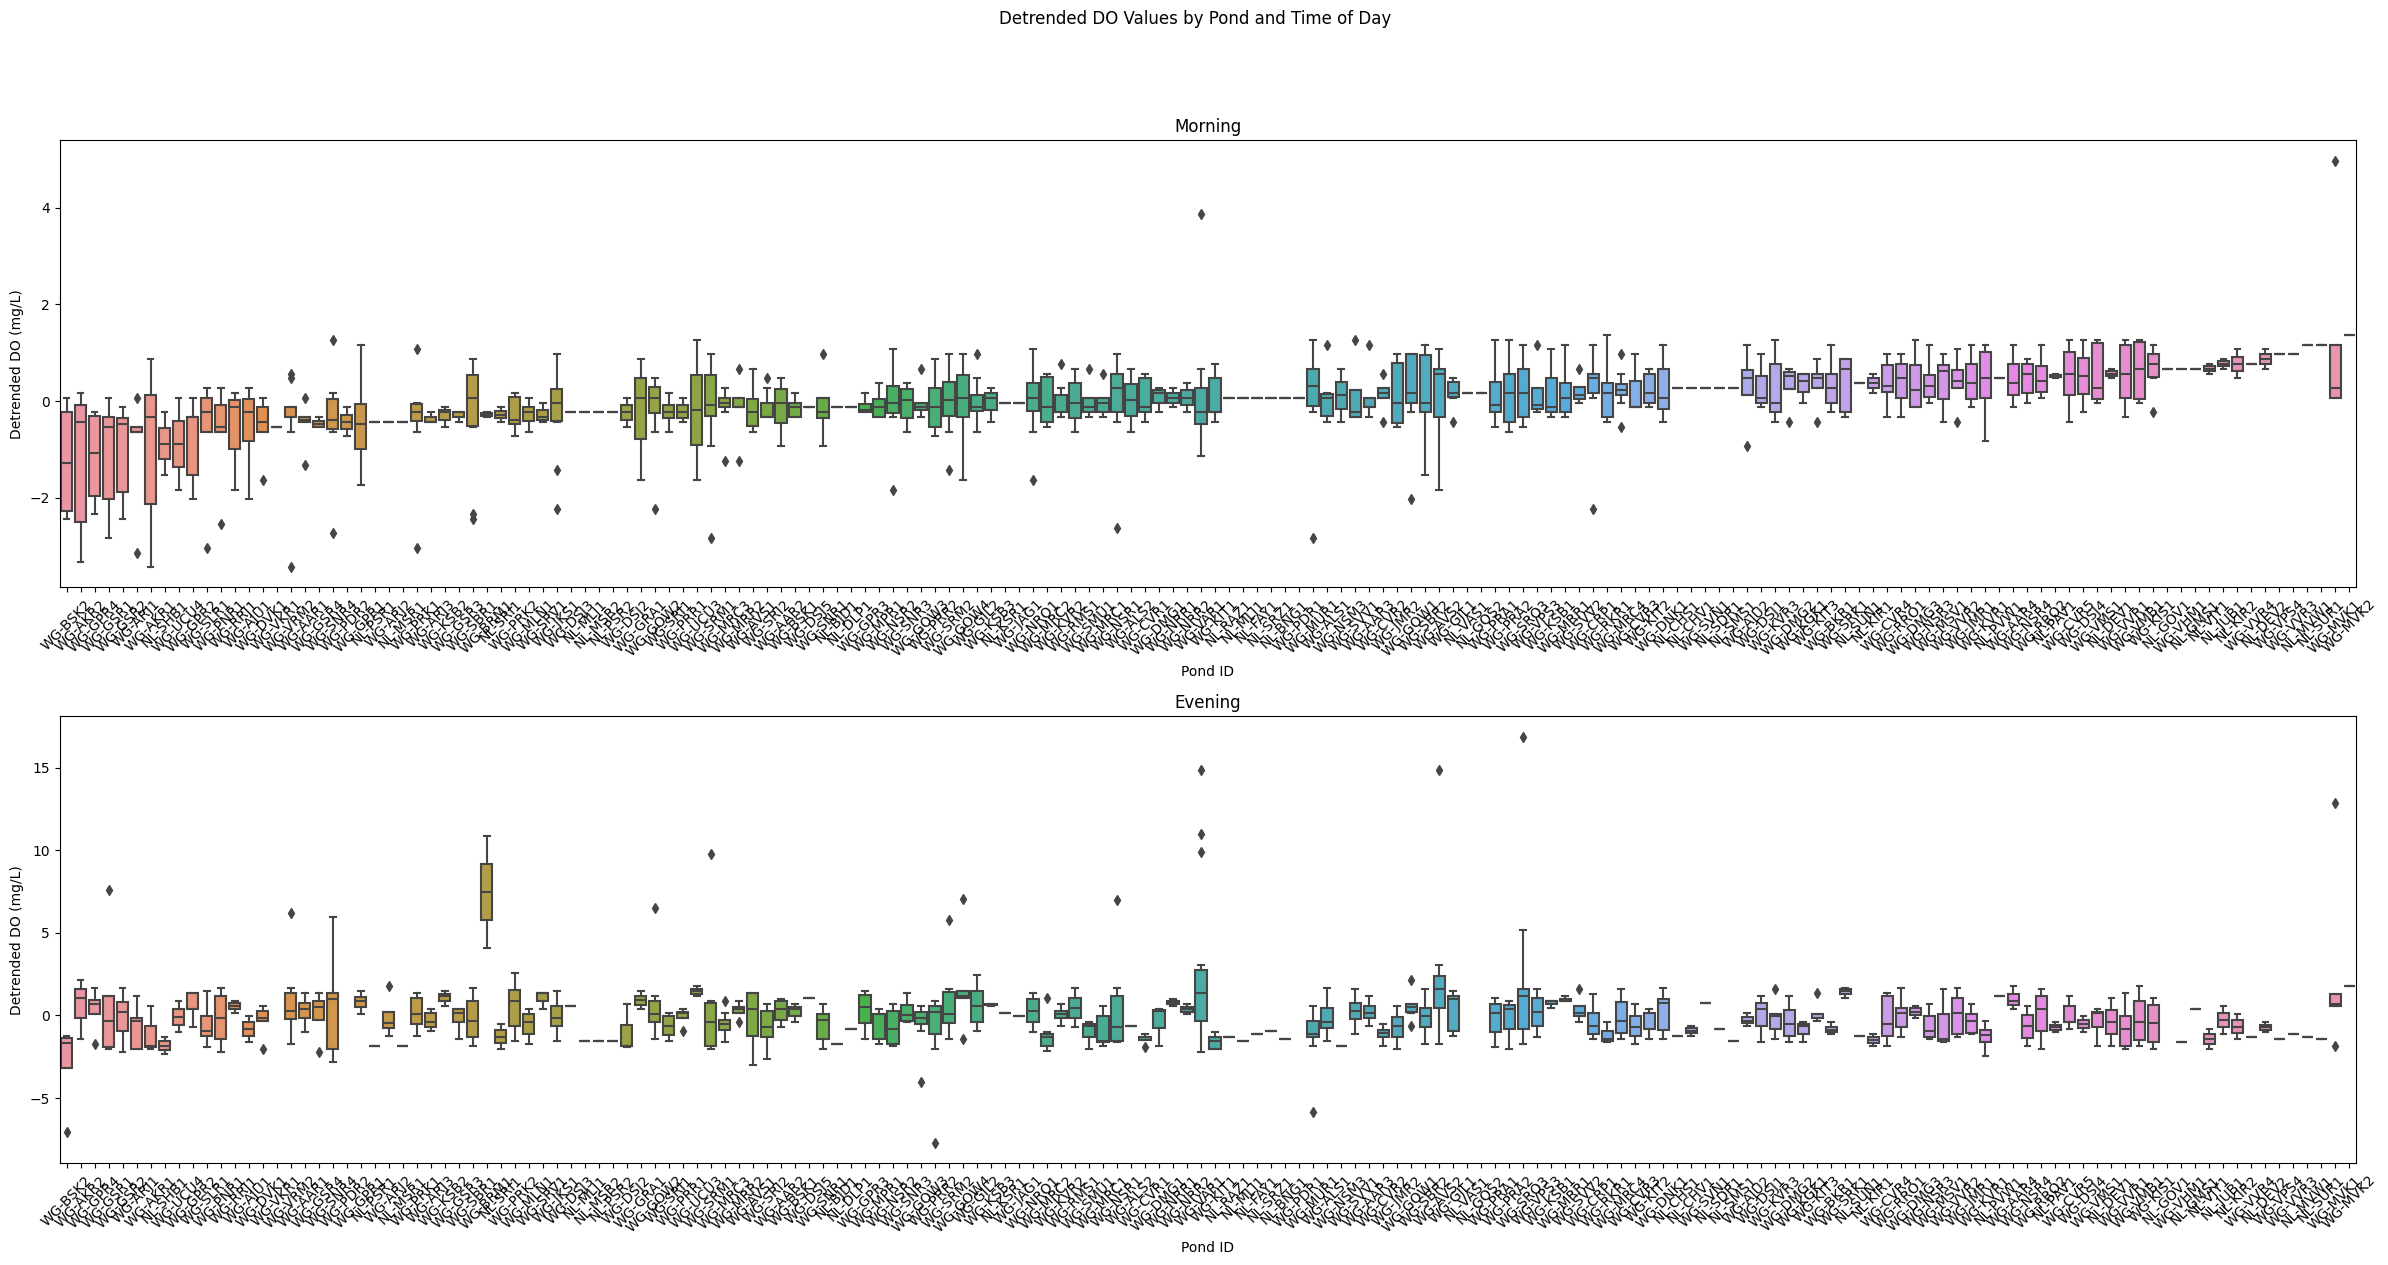

In [86]:
# Calculate morning means to sort ponds
morning_means = winkler_df[winkler_df['morning']].groupby(level='pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df[winkler_df['morning']]
sns.boxplot(data=morning_data, x=morning_data.index.get_level_values('pond_id'),
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df[~winkler_df['morning']]
sns.boxplot(data=evening_data, x=evening_data.index.get_level_values('pond_id'),
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day', y=1.05)
plt.tight_layout()
plt.show()


WG ponds definitely have lower water quality

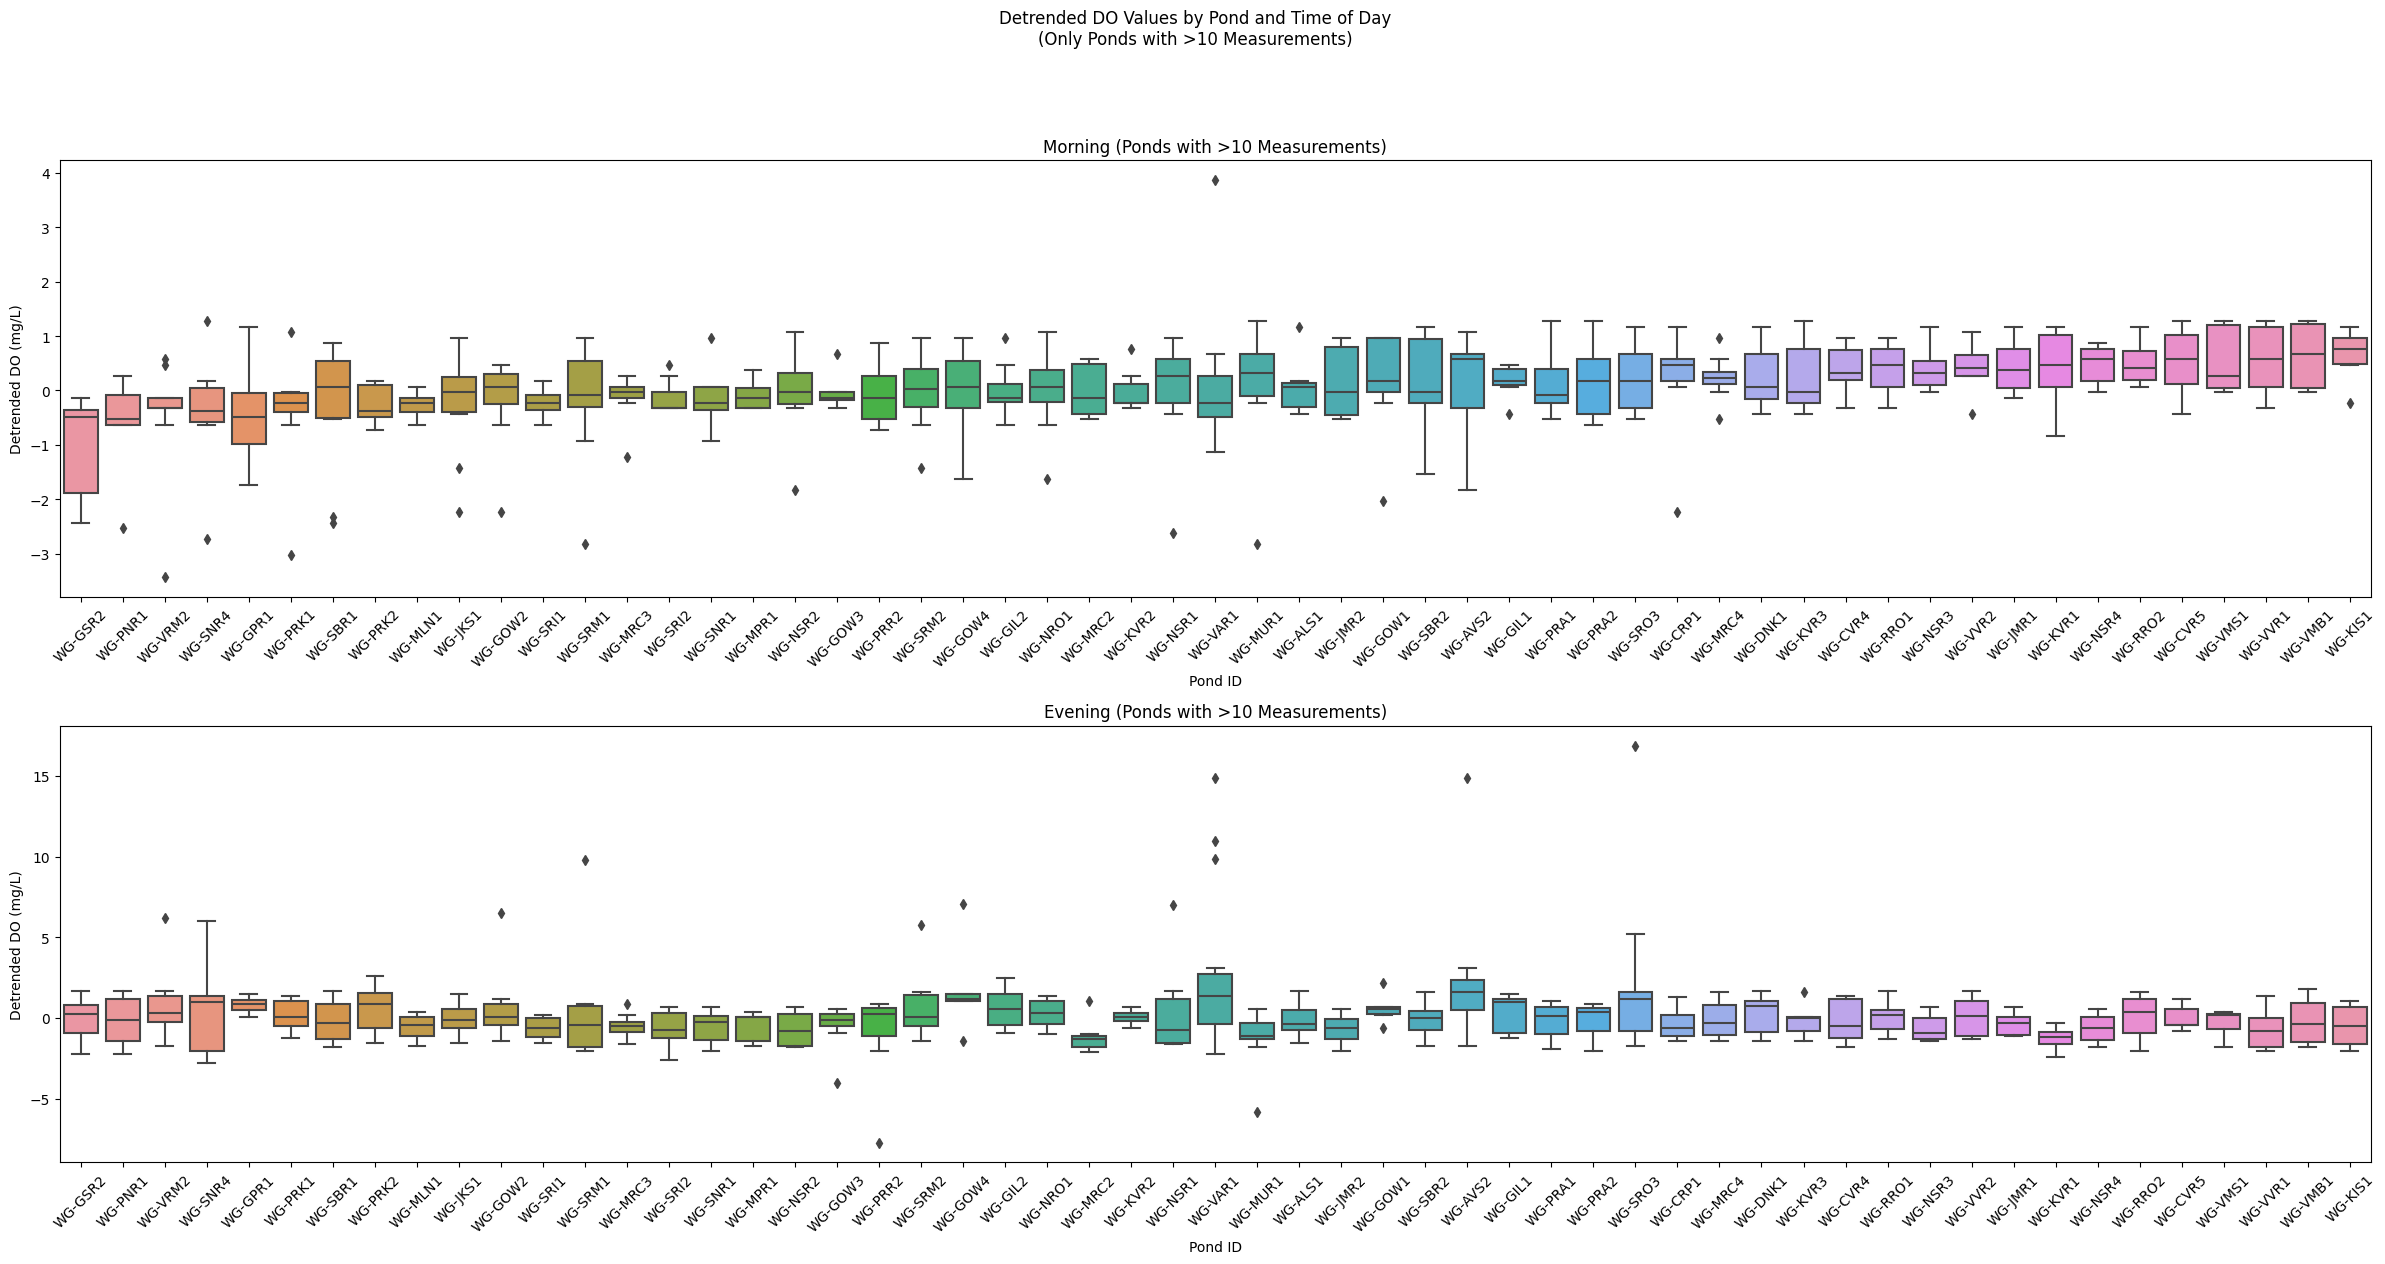

In [87]:
# Get ponds with more than 10 measurements
pond_counts = winkler_df.groupby(level='pond_id').size()
valid_ponds = pond_counts[pond_counts > 10].index

# Filter data for valid ponds
winkler_df_filtered = winkler_df[winkler_df.index.get_level_values('pond_id').isin(valid_ponds)]

# Calculate morning means to sort ponds
morning_means = winkler_df_filtered[winkler_df_filtered['morning']].groupby(level='pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df_filtered[winkler_df_filtered['morning']]
sns.boxplot(data=morning_data, x=morning_data.index.get_level_values('pond_id'),
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning (Ponds with >10 Measurements)')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df_filtered[~winkler_df_filtered['morning']]
sns.boxplot(data=evening_data, x=evening_data.index.get_level_values('pond_id'),
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening (Ponds with >10 Measurements)')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day\n(Only Ponds with >10 Measurements)', y=1.05)
plt.tight_layout()
plt.show()

In [90]:
feature_df.columns.tolist()

['region',
 'farm',
 'morning',
 'hour',
 'do_mg_per_L',
 'do_winkler',
 'prev_do_mg_per_L',
 'prev_ph',
 'prev_turbidity_cm',
 'prev_ammonia_mg_per_L',
 'prev_individuals_air_gulping',
 'prev_individuals_tail_splashing',
 'prev_dead_fish',
 'prev_feed_amount_kg',
 'prev_stocking_density_per_acre',
 'prev_weight',
 'prev_species_catla',
 'prev_species_rohu',
 'prev_species_roopchand',
 'prev_species_grass_carp',
 'prev_species_pangasius',
 'prev_species_whiteleg_shrimp',
 'property_area_acres',
 'pond_area_acres',
 'pond_depth_meters',
 'has_water_pump',
 'has_aerator',
 'has_motor_boat',
 'has_sprinkler',
 'pond_preparation',
 'village',
 'fertilizer_manure',
 'fertilizer_dap',
 'fertilizer_potash',
 'fertilizer_urea',
 'fertilizer_phosphate',
 'fertilizer_amm_sulph',
 'fertilizer_probiotics',
 'fertilizer_magnesium',
 'fertilizer_gromor',
 'fertilizer_lime',
 'fertilizer_none',
 'feed_type',
 'feed_source',
 'feed_brand',
 'feed_mash',
 'feed_pellets_float',
 'feed_pellets_sink',
 'f

In [106]:
# Calculate correlations separately for morning and evening
morning_data = winkler_df[winkler_df['morning']]
evening_data = winkler_df[~winkler_df['morning']]

# Calculate correlations for morning data
morning_corr = morning_data.corr()['do_mg_per_L_detrended'].abs()
morning_high_corr = morning_corr[morning_corr > 0.17].index.tolist()

# Calculate correlations for evening data  
evening_corr = evening_data.corr()['do_mg_per_L_detrended'].abs()
evening_high_corr = evening_corr[evening_corr > 0.17].index.tolist()

# Combine features that are important for either morning or evening
important_features = list(set(morning_high_corr + evening_high_corr))

# Remove target variables from features list
important_features = [col for col in important_features if col not in ['do_mg_per_L', 'do_mg_per_L_detrended']]

print("Number of important features:", len(important_features))
print("\nImportant features:")
print(important_features)


ValueError: could not convert string to float: 'NL'

In [123]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Create preprocessing pipeline with target encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline

# Prepare features and target
# Create features for all data
feature_df = winkler_df.copy()
feature_df = feature_df.drop(columns=['prev_matches_time', 'prev_sample_dt', 'do_in_range', 'village', 'feed_type', 'feed_source', 'feed_brand'])

# Add pond ID as categorical feature and encode categorical variables
categorical_columns = ['farm', 'region']
for col in categorical_columns:
    if col == 'pond_id':
        feature_df[col] = feature_df.index.get_level_values('pond_id').astype('category')
    else:
        feature_df[col] = feature_df[col].astype('category')

# Prepare features and target
X = feature_df.drop(['do_mg_per_L', 'do_mg_per_L_detrended'], axis=1)
X = X.drop(columns=(
    X.columns[X.columns.str.contains('wind')].tolist() +
    X.columns[X.columns.str.contains('_-33_|_21_')].tolist()
))
y = feature_df['do_mg_per_L_detrended']

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
categorical_features = X.select_dtypes(include=['category']).columns

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', 'drop', categorical_features)
    ],
    remainder='drop'
)

# Create initial pipeline for feature selection
feature_selection_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=150, min_samples_leaf=6, random_state=42)))
])

# Fit and transform data with feature selection using training data only
feature_selection_pipeline.fit(X_train, y_train)
selected_features_mask = feature_selection_pipeline.named_steps['selector'].get_support()

# Get selected feature names
selected_features = []
for feature, selected in zip(X.columns, selected_features_mask):
    if selected:
        selected_features.append(feature)

print(f"\nNumber of features selected: {len(selected_features)}")
print("\nSelected features:")
print(selected_features)

# Create X with only selected features for both train and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Create pipeline with selected features
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define parameter grid for pipeline
param_grid = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [5, 10, 15],
    'regressor__min_samples_leaf': [6, 8, 10]
}

# Initialize grid search with pipeline
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=1,
    scoring='r2',
    verbose=1
)

# Perform grid search on selected features using training data
grid_search.fit(X_train_selected, y_train)

# Print results of hyperparameter tuning
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.3f}")

# Create DataFrame of CV results for visualization
cv_results = pd.DataFrame(grid_search.cv_results_)

# Plot effects of key hyperparameters
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot effect of n_estimators
sns.boxplot(data=cv_results, x='param_regressor__n_estimators', y='mean_test_score', ax=ax1)
ax1.set_title('Effect of n_estimators')
ax1.set_ylabel('Mean CV Score (R²)')

# Plot effect of max_depth
sns.boxplot(data=cv_results, x='param_regressor__max_depth', y='mean_test_score', ax=ax2)
ax2.set_title('Effect of max_depth')
ax2.set_ylabel('Mean CV Score (R²)')

# Plot effect of min_samples_split
sns.boxplot(data=cv_results, x='param_regressor__min_samples_split', y='mean_test_score', ax=ax3)
ax3.set_title('Effect of min_samples_split')
ax3.set_ylabel('Mean CV Score (R²)')

# Plot effect of min_samples_leaf
sns.boxplot(data=cv_results, x='param_regressor__min_samples_leaf', y='mean_test_score', ax=ax4)
ax4.set_title('Effect of min_samples_leaf')
ax4.set_ylabel('Mean CV Score (R²)')

plt.tight_layout()
plt.show()

# Get feature importances for selected features
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
})

# Print top features
print("\nTop features by importance:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

# Evaluate model on test set
test_score = grid_search.score(X_test_selected, y_test)
print(f"\nTest set R² score: {test_score:.3f}")

# Plot feature importances
plt.figure(figsize=(12, 6))
feature_importance_sorted = feature_importance.sort_values('importance', ascending=True)
plt.barh(range(len(feature_importance_sorted)), feature_importance_sorted['importance'])
plt.yticks(range(len(feature_importance_sorted)), feature_importance_sorted['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Selected Features)')
plt.tight_layout()
plt.show()



Number of features selected: 30

Selected features:
['hour', 'do_winkler', 'prev_dead_fish', 'prev_weight', 'pond_area_acres', 'pond_depth_meters', 'has_motor_boat', 'fertilizer_manure', 'fertilizer_dap', 'fertilizer_phosphate', 'fertilizer_none', 'feed_pellets_float', 'downward_shortwave_radiation_flux_-33', 'downward_shortwave_radiation_flux_39', 'downward_shortwave_radiation_flux_same_day_sum', 'downward_shortwave_radiation_flux_sample', 'downward_shortwave_radiation_flux_seven_day_cum', 'precipitable_water_entire_atmosphere_same_day_sum', 'precipitable_water_entire_atmosphere_sample', 'relative_humidity_2m_above_ground_39', 'relative_humidity_2m_above_ground_same_day_sum', 'relative_humidity_2m_above_ground_sample', 'specific_humidity_2m_above_ground_before_day_sum', 'specific_humidity_2m_above_ground_same_day_sum', 'total_cloud_cover_entire_atmosphere_-9', 'total_precipitation_surface_-33', 'total_precipitation_surface_33', 'total_precipitation_surface_39', 'total_precipitation_s

ValueError: 
All the 540 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'morning'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\utils\_indexing.py", line 361, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'morning'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\utils\_indexing.py", line 369, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


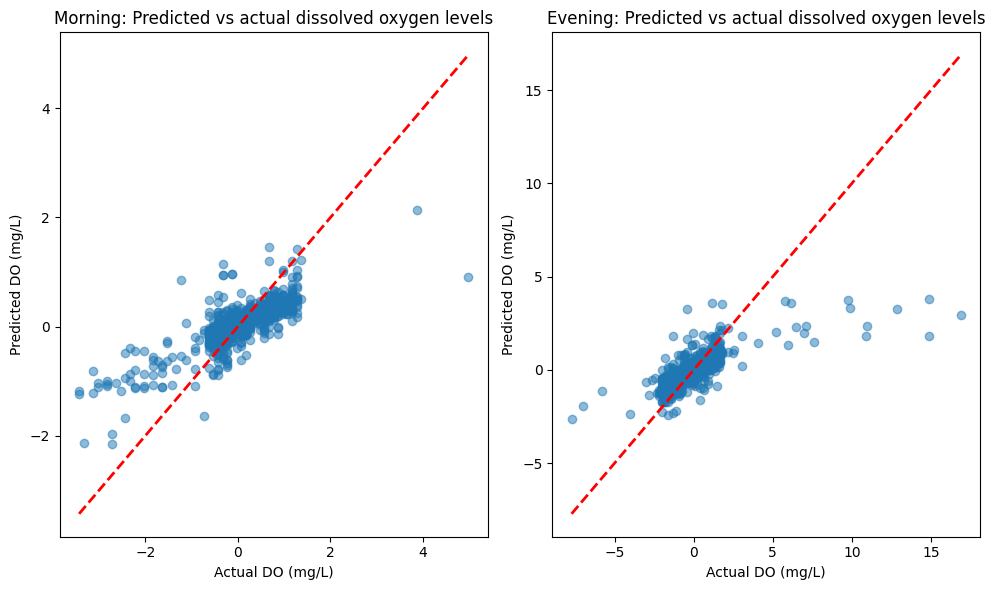

In [ ]:
# Get predictions from best model on test set
y_pred_test = grid_search.best_estimator_.predict(X_test_selected)

# Split test data into morning and evening
morning_mask = X_test['morning'] == True
evening_mask = X_test['morning'] == False

# Create scatter plots for morning and evening
plt.figure(figsize=(10, 6))

# Morning plot
plt.subplot(1, 2, 1)
plt.scatter(y_test[morning_mask], y_pred_test[morning_mask], alpha=0.5)
plt.plot([y_test[morning_mask].min(), y_test[morning_mask].max()], 
         [y_test[morning_mask].min(), y_test[morning_mask].max()], 'r--', lw=2)
plt.xlabel('Actual DO (mg/L)')
plt.ylabel('Predicted DO (mg/L)')
plt.title('Morning: Predicted vs actual dissolved oxygen levels (test set)')

# Evening plot  
plt.subplot(1, 2, 2)
plt.scatter(y_test[evening_mask], y_pred_test[evening_mask], alpha=0.5)
plt.plot([y_test[evening_mask].min(), y_test[evening_mask].max()],
         [y_test[evening_mask].min(), y_test[evening_mask].max()], 'r--', lw=2)
plt.xlabel('Actual DO (mg/L)')
plt.ylabel('Predicted DO (mg/L)')
plt.title('Evening: Predicted vs actual dissolved oxygen levels (test set)')

plt.tight_layout()
plt.show()


Metrics for below range DO:
Number of samples: 67
MSE: 2.810
R²: 0.125
Precision: 0.745
Recall: 0.612
Classification accuracy: 61.2%

Metrics for within range DO:
Number of samples: 1325
MSE: 0.328
R²: 0.968
Precision: 0.974
Recall: 0.979
Classification accuracy: 97.9%

Metrics for above range DO:
Number of samples: 25
MSE: 40.106
R²: -0.664
Precision: 0.548
Recall: 0.680
Classification accuracy: 68.0%


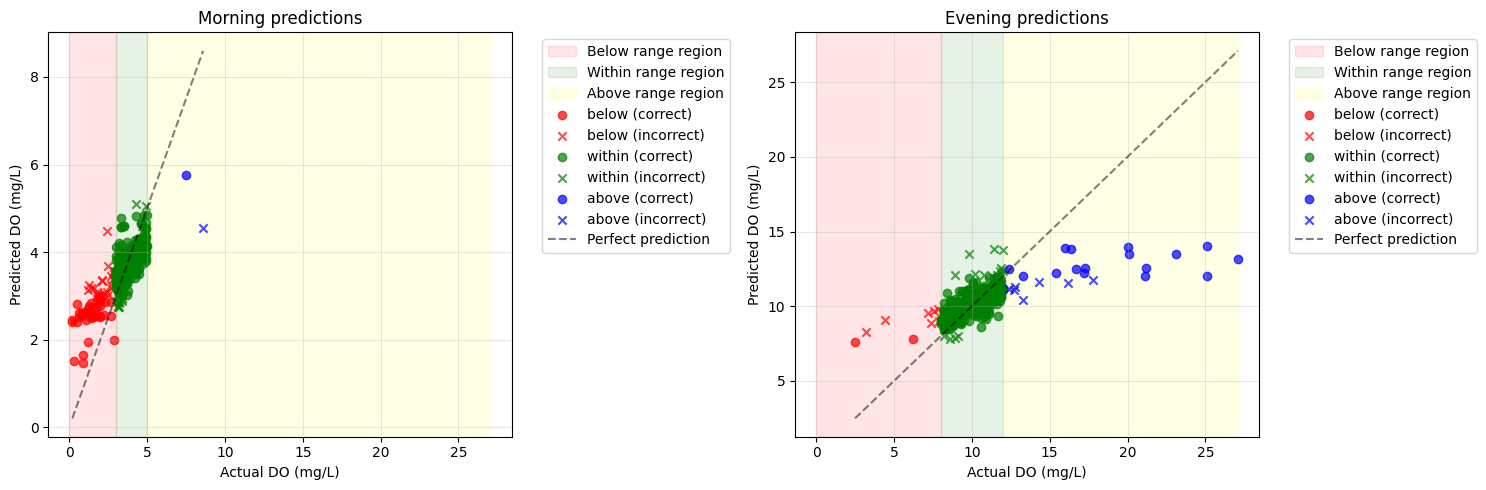

In [120]:
# Use the get_in_required_range function to classify DO measurements
from fwi_predict.wq import get_in_required_range
from fwi_predict.constants import WQ_RANGES
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score

# Get range classifications for actual and predicted values
time_of_day = X_test['morning'].apply(lambda x: 'morning' if x else 'evening')

# Add back diurnal trends to actual and predicted values
# Calculate diurnal means from winkler df
morning_mean = winkler_df[winkler_df['morning']]['do_mg_per_L'].mean()
evening_mean = winkler_df[~winkler_df['morning']]['do_mg_per_L'].mean()

# Apply diurnal means based on time of day
diurnal_means_test = X_test['morning'].map({True: morning_mean, False: evening_mean})

y_test_with_trend = y_test + diurnal_means_test
y_pred_test_with_trend = y_pred_test + diurnal_means_test

actual_range = get_in_required_range('do_mg_per_L', y_test_with_trend, time_of_day)
predicted_range = get_in_required_range('do_mg_per_L', y_pred_test_with_trend, time_of_day)

# Calculate accuracy metrics for each range category
categories = ['below', 'within', 'above']
for category in categories:
    # Create masks for actual and predicted categories
    actual_mask = actual_range == category
    pred_mask = predicted_range == category
    
    # Calculate metrics if we have data in this category
    if actual_mask.any():
        category_mse = mean_squared_error(y_test_with_trend[actual_mask], y_pred_test_with_trend[actual_mask])
        category_r2 = r2_score(y_test_with_trend[actual_mask], y_pred_test_with_trend[actual_mask])
        n_samples = actual_mask.sum()
        
        # Calculate precision and recall
        precision = precision_score(actual_range == category, predicted_range == category)
        recall = recall_score(actual_range == category, predicted_range == category)
        
        print(f"\nMetrics for {category} range DO:")
        print(f"Number of samples: {n_samples}")
        print(f"MSE: {category_mse:.3f}")
        print(f"R²: {category_r2:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        
        # Calculate classification accuracy
        correct_classifications = (actual_range == predicted_range)[actual_mask].mean()
        print(f"Classification accuracy: {correct_classifications:.1%}")

# Visualize predictions by time of day
plt.figure(figsize=(15, 5))

# Plot for morning and evening
colors = {'above': 'blue', 'within': 'green', 'below': 'red'}
do_ranges = WQ_RANGES['do_mg_per_L']['required']

for i, tod in enumerate(['morning', 'evening']):
    plt.subplot(1, 2, i+1)
    tod_mask = time_of_day == tod
    
    # Create a grid to show the different prediction regions
    plt.axvspan(0, do_ranges[tod][0], alpha=0.1, color='red', label='Below range region')
    plt.axvspan(do_ranges[tod][0], do_ranges[tod][1], alpha=0.1, color='green', label='Within range region')
    plt.axvspan(do_ranges[tod][1], max(y_test_with_trend.max(), y_pred_test_with_trend.max()), alpha=0.1, color='yellow', label='Above range region')
    
    # Plot points for each category (above, within, below) and prediction accuracy
    for category in categories:
        category_mask = tod_mask & (actual_range == category)
        correct_mask = category_mask & (actual_range == predicted_range)
        incorrect_mask = category_mask & (actual_range != predicted_range)
        
        # Plot correct predictions
        plt.scatter(y_test_with_trend[correct_mask], y_pred_test_with_trend[correct_mask],
                   alpha=0.7, c=colors[category], marker='o',
                   label=f'{category} (correct)')
        
        # Plot incorrect predictions
        plt.scatter(y_test_with_trend[incorrect_mask], y_pred_test_with_trend[incorrect_mask],
                   alpha=0.7, c=colors[category], marker='x',
                   label=f'{category} (incorrect)')

    # Add diagonal line for perfect predictions
    plt.plot([y_test_with_trend[tod_mask].min(), y_test_with_trend[tod_mask].max()],
             [y_test_with_trend[tod_mask].min(), y_test_with_trend[tod_mask].max()],
             'k--', alpha=0.5, label='Perfect prediction')
    
    plt.xlabel('Actual DO (mg/L)')
    plt.ylabel('Predicted DO (mg/L)')
    plt.title(f'{tod.capitalize()} predictions')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [94]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__min_samples_leaf,param_regressor__min_samples_split,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,15.371013,1.435406,0.036670,0.018829,None,2,2,50,"{'regressor__max_depth': None, 'regressor__min...",0.036308,-0.110198,0.064087,-0.063931,0.009229,-0.012901,0.064667,37
1,28.316143,1.441806,0.036504,0.011176,None,2,2,100,"{'regressor__max_depth': None, 'regressor__min...",0.028071,-0.127107,0.090248,0.005659,0.011967,0.001768,0.071061,21
2,13.797252,1.380629,0.017744,0.005133,None,2,5,50,"{'regressor__max_depth': None, 'regressor__min...",0.040692,-0.142170,0.081657,-0.034403,-0.004560,-0.011757,0.076222,35
3,28.942373,2.449024,0.037084,0.018600,None,2,5,100,"{'regressor__max_depth': None, 'regressor__min...",0.023423,-0.164847,0.080498,-0.033428,0.009429,-0.016985,0.082422,42
4,14.032401,1.136920,0.042220,0.030251,None,2,10,50,"{'regressor__max_depth': None, 'regressor__min...",0.008305,-0.110436,0.059864,-0.076531,0.009103,-0.021939,0.062261,45
5,25.642617,2.236682,0.033893,0.009824,None,2,10,100,"{'regressor__max_depth': None, 'regressor__min...",0.034239,-0.146301,0.078032,-0.033803,0.014313,-0.010704,0.076733,34
6,11.806028,0.642824,0.026817,0.013410,None,4,2,50,"{'regressor__max_depth': None, 'regressor__min...",0.063386,-0.075879,0.082150,-0.073451,0.015980,0.002437,0.066550,20
7,23.438929,1.856102,0.030526,0.014650,None,4,2,100,"{'regressor__max_depth': None, 'regressor__min...",0.079793,-0.102413,0.104875,-0.003040,0.033273,0.022498,0.072718,1
8,12.153438,0.477290,0.033795,0.019244,None,4,5,50,"{'regressor__max_depth': None, 'regressor__min...",0.068930,-0.083219,0.103364,-0.055011,0.014789,0.009771,0.070892,12
9,21.823327,0.662770,0.036228,0.014226,None,4,5,100,"{'regressor__max_depth': None, 'regressor__min...",0.063431,-0.111616,0.096467,-0.021850,0.036662,0.012619,0.073230,9
